**Welcome**
This notebook summarizes the research in comparing data from the HiTS database and from the LSST Database. Both are programs that store and analyze data. Our goal is to compare the differences inhope of imroving the software and finding undetected objects

In [1]:
%matplotlib inline 

Below are import statments that we will use to plot and retrieve data

In [9]:
import os
from astropy.io import fits
import pandas as pd
import sys
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import tarfile
from astropy import units as u 
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay

**Looking at the Data**
Apart of this project is comparing data from HiTS and newfound data from LSST. Let's look at the HiTS data!`m


In [7]:
#Here we use Butler to get an image within the data for us
testdataId = {'visit': 413696, 'ccdnum':47}
processedImage = butler.get('calexp', dataId=testdataId)

In [ ]:
#Here we display the image
display = afwDisplay.Display(frame=1)
display.mtv(processedImage)
#Below are filters to see the image better and with more contrast
display.setMaskTransparency(50)
display.scale('linear', 'zscale')
display.show_colorbar()

In [11]:
#Now we will look at the difference image
differenceImage = butler.get('deepDiff_differenceExp', dataId=testdataId)

In [ ]:
#Displaying the difference image with filters
display2 = afwDisplay.Display(frame=2)
display2.mtv(differenceImage)
display2.setMaskTransparency(50)
display2.scale('linear', 'zscale')
display2.show_colorbar()

**Clearing confusion about the data**
Sources are things that we detect in a difference image
objects are a set of sources that are associated together because they are in the same place

**Plotting objects and sources on the sky**
Now we will gain an even closer look by plotting our objects and sources on the sky. To do this...

In [13]:
connection = sqlite3.connect(dbPath)
#Connect to the database and pull the data that we need

connect to database (called 'association.db') using sqlite , and read the data into panadas several tables in this database: 
* DiaForcedSource
* DiaSource
* DiaObject
* PpdbProtoVisits
* DiaObjects_To_Objects_Match
* SSObjects

"Dia" means "Difference Image Analysis." "Ppdb" means "Prompt Products Database." "Forced" refers to forced photometry (even if there is no source detected at a location, maybe there was before, so measure the brightness there anyway. "SS: refers to Solar System and we won't worry about that..

In [14]:
#combining a data set into an array to be read; Incorporating data into a table consisting of only what is read. 
objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources, gPSFluxMean, validityEnd, flags, gTOTFluxMean, GTOTFluxMeanErr, gPSFluxMeanErr from DiaObject where validityEnd is NULL;', connection)

Text(0.5, 1.0, 'Course overview of where objets are in the sky')

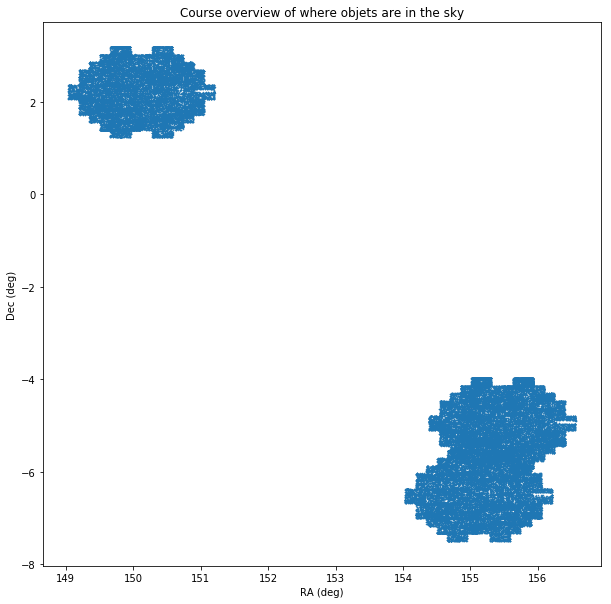

In [15]:
#Here we will visually show where the data captured by the ccd lies in terms of degrees. 
fig = plt.figure(figsize=(10,10))
#RA vs DECL gives the visual layout of the visit...within that shapes appearing include objects.
plt.scatter(objTable['ra'], objTable['decl'], s=1, marker='.')
#labeling axes
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('Course overview of where objets are in the sky')

Text(0.5, 1.0, 'Course overview of where objets are in the sky')

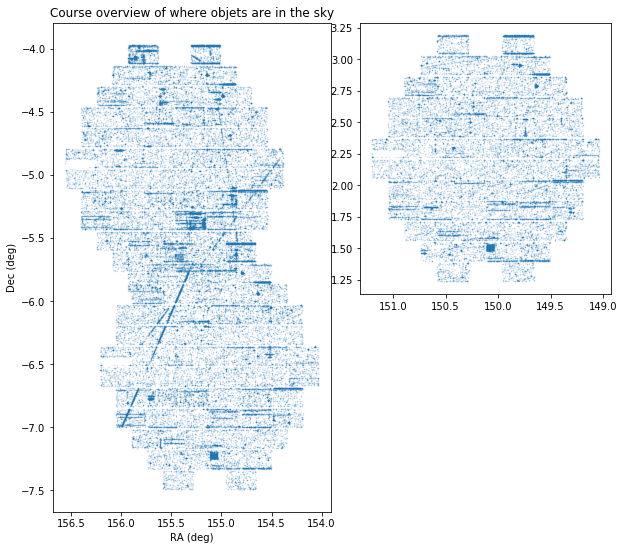

In [16]:
#Here i set the size of the figure
fig = plt.figure(figsize=(10,10))
#Here ax1 and ax2 will add a new set of axes for two graphs
ax1 = plt.subplot2grid((100,100), (0,55), rowspan=50, colspan= 45)
ax2 = plt.subplot2grid((100,100), (0,0), rowspan = 90, colspan= 50)
#Filtering data that is plotted
ax1Filter = (objTable['decl'] > -2)
#inverse of ax1Filter, we do this to filter the data...
ax2Filter = (~ax1Filter)
#creating the scatter plot
scatter1 = ax1.scatter(objTable.loc[ax1Filter,'ra'], objTable.loc[ax1Filter,'decl'], marker= '.', s=0.5, alpha=0.2)
scatter2= ax2.scatter(objTable.loc[ax2Filter,'ra'], objTable.loc[ax2Filter,'decl'], marker= '.', s=0.5, alpha= 0.2)
#invert axises to get the right orientation of the data
ax1.invert_xaxis()
ax2.invert_xaxis()
#here we label our axes
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('Course overview of where objets are in the sky')

**All the Data**
Above is all the data that we will analyze. They fit within a geometric shape, defiend by the telescope that observed them. This data makes up a small portion of the sky. Later we will filter out bad data (edges, saturation, etc).

**Using LSST**
Now we want to use LSST dataframes for the HiTS data and compare the similarities and differences that we see. Below we will plot both the HiTS light curves and the LSST light curves to see how they compare

**First lets compare the objects on the sky**
Below is a function that similar to the one above with plot all the source and objects on the sky. However with this one we will plot both the sources and objects from the HiTS and LSST data.
**Objective**
Within this Notebook, we will plot lights curves from HiTS data, new LSST data. To plot these light curves, we will remove the bad flags (data that is bad) and plot only the good data we retrieved. Later we will plot both together and see what differences we spot.  

In [43]:
def plot_objects_on_sky(ra1_first, dec1_first,
                        ra2_first, dec2_first,
                        ra1_second, dec1_second,
                        ra2_second, dec2_second):
    """This function takes two sets of RA and Dec and plots them
    both on the sky in different colors.
    
    It is customized to plot a specific region (three HiTS fields in two panels).
    
    "1" and "2" refer to the two panels in the plot.
    "first" and "second" refer to the two different datasets.
    """
    # Set up the figure object and two axes
    fig = plt.figure(figsize=(13, 13))
    ax1 = plt.subplot2grid((100, 100), (0, 55), rowspan=50, colspan=45)
    ax2 = plt.subplot2grid((100, 100), (0, 0), rowspan=90, colspan=50)

    # Plot the first set of RAs and Decs in blue
    # This will be from the LSST database
    ax1.scatter(ra1_first, dec1_first, marker='.', s=0.5, alpha=0.5, c='C0',label='LSST')
    ax2.scatter(ra2_first, dec2_first, marker='.', s=0.5, alpha=0.5, c='C0',label='LSST')
    
    # Plot the second set of RAs and Decs in red
    # This will be from the HiTS DR1
    ax1.scatter(ra1_second, dec1_second, marker='.', s=20, alpha=0.8, c='red',label='HiTS')
    ax2.scatter(ra2_second, dec2_second, marker='.', s=20, alpha=0.8, c='red',label='HiTS')

    ax1.invert_xaxis()
    ax2.invert_xaxis()
    
    # Label axes and title plot
    plt.xlabel('RA (deg)', fontsize=14)
    plt.ylabel('Dec (deg)', fontsize=14)
    plt.title('View of Objects from LSST and HiTS on the Sky', fontsize=15.5)
    
    # Increase x and y tick text size
    ax1.tick_params(axis='both', which='major', labelsize=11.5)
    ax1.tick_params(axis='both', which='minor', labelsize=11.5)

    ax2.tick_params(axis='both', which='major', labelsize=11.5)
    ax2.tick_params(axis='both', which='minor', labelsize=11.5)
    
    # Generate legends
    lgnd = ax1.legend(loc="lower right", scatterpoints=1, fontsize=10, prop={'size': 11.5})
    lgnd.legendHandles[0]._sizes = [60]
    lgnd.legendHandles[1]._sizes = [60]
    
    lgnd2 = ax2.legend(loc="lower right", scatterpoints=1, fontsize=10, prop={'size': 11.5})
    lgnd2.legendHandles[0]._sizes = [60]
    lgnd2.legendHandles[1]._sizes = [60]

In [44]:
# Defines filters and parameters to be called by plot_objects_on_sky()
ax1Filter = (goodObj['decl']>-2)
ax2Filter=(~ax1Filter)
#The goodobj is defined below. These objects are absent of suspect or saturation
ra1_first=goodObj.loc[ax1Filter, 'ra']
dec1_first=goodObj.loc[ax1Filter, 'decl']
ra2_first=goodObj.loc[ax2Filter, 'ra']
dec2_first=goodObj.loc[ax2Filter, 'decl']
#Filtering out the second set of data
ax1Filter_second = (hitsDf['decMedian']>-2)
ax2Filter_second = (~ax1Filter_second)
#applying these filters
ra1_second=hitsDf.loc[ax1Filter_second,'raMedian']
dec1_second=hitsDf.loc[ax1Filter_second,'decMedian']
ra2_second=hitsDf.loc[ax2Filter_second,'raMedian']
dec2_second=hitsDf.loc[ax2Filter_second,'decMedian']

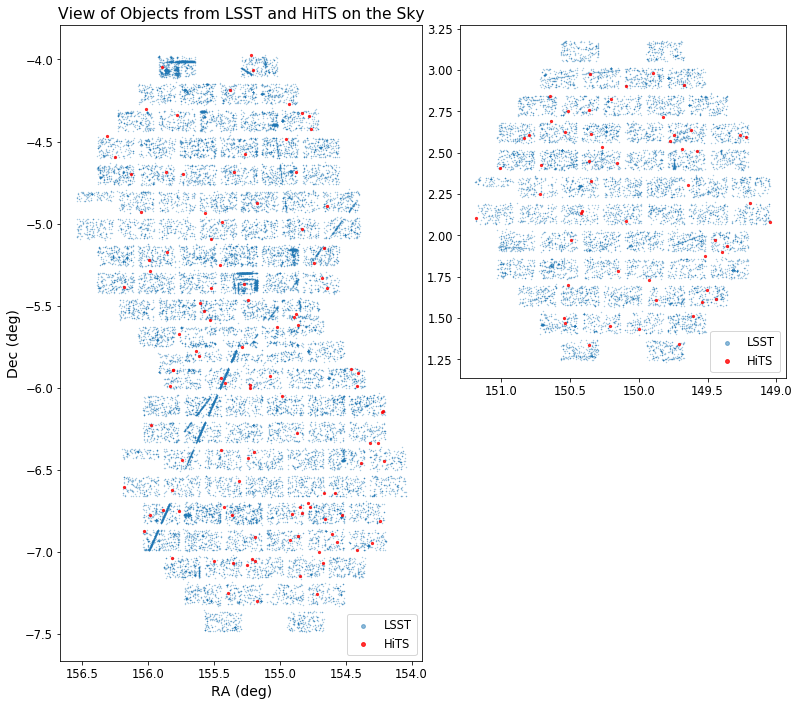

In [45]:
#plotting the image of the sky. This is all the data that we are looking at!
plot_objects_on_sky(ra1_first, dec1_first,
                        ra2_first, dec2_first,
                        ra1_second, dec1_second,
                        ra2_second, dec2_second)

**Locating and Accessing the HiTS Data**
Below we locate and retrieve data from HiTS to arrange into a table

In [17]:
hitsDataDir= '/epyc/users/mrawls/premap2019/hits-dr1' #This is the path where the HiTS light curves are
hitsFilename= 'HiTS_DR1_variables_DM-dataset-subset.fits' #The file name in which there are light curves
hitsFilepath = os.path.join(hitsDataDir, hitsFilename)  #This creates a path to retrieveing the light curves
hitsTable= fits.open(hitsFilepath) #load data as an astropy fits table
hitsDf= pd.DataFrame(hitsTable[1].data) #turn data into a pandas dataframe
hitsDf.head()#shows us (prints out) what the dataframe looks like
print(len(hitsDf))
#hitsDf.columns  #all of the things we can access from the data 82 columns

165


**Plotting HiTS light curves**
Here we have a function that will use a row from the table and import data from the hits-dr1 database
The output will be a light curve from the object that we choose

In [18]:
# These are the two variables which will be used to plot the light curves from HiTS. The row indicated the specific object and the lcPath defines where to find it. 
def plot_hits(row, lcPath='/epyc/users/mrawls/premap2019/hits-dr1/light_curves'):
    '''Plots light curves from HiTS dr1. 
    
    Parameters
    ----------
    row: Pandas dataframe row from DR1 source data 
    lcPath: Path on disk to light curves from DR1'''
    #The first two rows below define the object we are wanting to see the light curve of
    tok = row['internalID'].split('_')
    ccd = tok[2]
    #field and lightcurveFile define a location for finding this object
    field = '_'.join([tok[0], tok[1]])
    lightcurveFile= field + '_' + ccd + '_LC_50.tar.gz'
    #lightcurvePath= os.path.join(hitsDataDir, 'light_curves', field, ccd, lightcurveTestFile)
    #Below we are accessing the data and retrieving it 
    tarball = tarfile.open(os.path.join(lcPath, field, ccd, lightcurveFile))
    data = tarball.extractfile(row['internalID'] + '_g.dat')
    dfl = pd.read_csv(data, sep='\t') # load a file with light curve data into the pandas datafram
    #The last step is to use matplotlib and plot the data recieved
    fig = plt.figure (figsize = (6, 4))
    plt.errorbar(dfl.MJD, dfl.MAG_AP1, dfl.MAGERR_AP1, marker='o', linestyle= ':')
    plt.xlabel('Time (MJD)')
    plt.ylabel('magnitude')

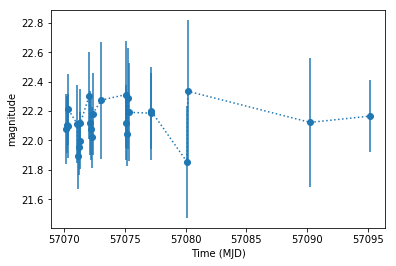

In [19]:
plot_hits(hitsDf.iloc[22]) #This is the result of the function above

**Accessing Lsst Data**
We will use Butler, pandas and sqlite to access Lsst

In [20]:
repo = '/epyc/users/mrawls/premap2019/hits-lsst/hits2015/rerun/highres1'
butler = dafPersist.Butler(repo) #Butler is used for data retrieval 

In [21]:
#Form a path to the Database
dbName = 'association.db'
dbPath = os.path.join(repo, dbName)

We are connecting to the database using sqlite3. This will make two pandas dataframes. One is all the objects and one is all the sources. 

In [22]:
connection = sqlite3.connect(dbPath)

In [23]:
objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources, \
                              gPSFluxMean, gPSFluxMeanErr, \
                              validityEnd, flags, \
                              gTOTFluxMean, gTOTFluxMeanErr \
                              from DiaObject where validityEnd is NULL;', connection)

Above we have imported/selected all the data from **OBJECTS** that we want from the columns to arange in a table

In [24]:
srcTableAll = pd.read_sql_query('select diaSourceId, diaObjectId, \
                                  ra, decl, ccdVisitId, \
                                  midPointTai, apFlux, psFlux, apFluxErr, \
                                  psFluxErr, totFlux, totFluxErr, flags \
                                  from DiaSource;', connection)

Above we have imported/selected all the data from **SOURCES** that we want from the columns ot arange in a table

**Removing Bad Data**
Below we will sort the data into a new table and apply filters to that table

In [25]:
sys.path.append('/epyc/users/mrawls/premap2019/ap_pipe-notebooks/')
from apdbPlots import makeSrcTableFlags #Here we are 'relocating' the data into a new table

In [26]:
badFlagList = ['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_saturatedCenter']
#Bad Data is any objects/source/data that has been deemed bad, suspect (could be bad), and saturated (affects the light curves)

**Sorting through our Data**
Within our new table, there is a lot of data, we must assign variable names to these 

In [27]:
#Below are the variables names that will organize the data into the table
lagTable, flagValues, srcTableFlags, flagFilter, noFlagFilter, \
    goodSrc, goodObj = makeSrcTableFlags(srcTableAll, objTable) #This is making a new table of data without the bad flags!

/epyc/users/mrawls/lsst_stack/stack/miniconda3-4.5.12-f032070/Linux64/ap_association/18.1.0-14-g371438c+1/python/lsst/ap/association/mapApData.py:388: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  table_list = list(yaml.load_all(yaml_stream))


In [28]:
#Here we filter through the raw data and obtain only the good data
lsstRas = goodObj.ra
lsstDecs = goodObj.decl
hitsRas = hitsDf.raMedian_feat
hitsDecs = hitsDf.decMedian_feat #Altering the data so for regular function we only get good data

Now we have RA and Decs for both. We want to compare LSST catalogs to Objects in HiTS, but we need something to organize them so that they line up 

In [29]:
hitsCoords = SkyCoord(ra=hitsRas*u.degree, dec=hitsDecs*u.degree) #This allows us to convert the degrees between the different measurment methods
lsstCoords = SkyCoord(ra=lsstRas*u.degree, dec=lsstDecs*u.degree)
idx, d2d, d3d = hitsCoords.match_to_catalog_sky(lsstCoords)#This will compare directly one to another wihtin indices
idx  # these are the indices of lsstCoords corresponding to hitsCoords 0, 1, 2, ...

array([23275, 13946, 38703, 11859, 37400,  7466, 22264, 30986, 35177,
       17819, 35180, 38621, 14858, 38394, 19642, 33543,  5618,  7250,
       26124, 12019,  5620, 13801, 11852,  4423, 37147, 38878, 11856,
       28509, 32548, 15050, 31216, 19544, 37528, 17790, 38535, 24220,
       29636,  1112, 35274, 37883, 38935, 38133,  4418, 19840,  7312,
       38058, 38045, 38660,  5780, 37761, 38470, 38504, 37721, 35266,
        1427, 26816, 40799, 14142, 31506, 12372, 12452, 34101,  4851,
       40408, 41545,  1396, 27768, 41709, 39382, 41681,  8892, 19108,
       20399, 10643, 15201, 41226, 43168, 18239, 41370, 25797, 19007,
       17005,  4937, 35334, 44044, 39285,  8362, 15211, 41237,  3927,
        4644, 40330,  3868, 36257, 44435, 39291, 41012, 43615,   717,
       40638, 45124, 44614,  6693, 31487, 41266, 42057, 31288, 44838,
       42051, 44860, 22561, 24612,  5166,   245, 42055, 11226, 36515,
       16150, 17043, 43855, 17165, 33894, 12943, 12757, 12469, 24685,
       15823, 40558,

**Plotting LSST Light Curves** 
Below we have a function to plot our new LSST light curves

In [30]:
def plotLsstLightcurve(obj, dbPath, fluxCol='totFlux'):
    '''Plots a light curve for a DIA (Difference Image Analysis) Object
    from an LSST APDB (Alert Production database).
    
    Parameters
    ----------
    obj : diaObjectId
        a really long integer that lets us retrieve sources for a single object
    objTable : Pandas dataframe containing DIA Objects
    repo : Butler repository
    dbPath : Path on disk to an APDB we can load DIA Objects or DIA Sources from
        often the database is named `association.db`
    fluxCol : Which flux column to plot?
        choices are totFlux, psFlux, apFlux
    
    '''
    plt.figure(figsize=(6,4))
    connection = sqlite3.connect(dbPath)
    # Load all sources for a single object called "obj"
    srcTable = pd.read_sql_query(f'select diaSourceId, diaObjectId, \
                                  ra, decl, ccdVisitId, \
                                  midPointTai, apFlux, psFlux, apFluxErr, \
                                  psFluxErr, totFlux, totFluxErr, flags \
                                  from DiaSource where diaObjectId = {obj};', connection)
    #The parameters for the light curve
    fluxErrCol = fluxCol + 'Err' #This is the Error that will be incorporated into our light curves 
    plt.errorbar(srcTable['midPointTai'], srcTable[fluxCol], yerr=srcTable[fluxErrCol],
                 ls=':', marker='o') #These will all contribute to the y-axis
    plt.ylabel(fluxCol + ' (nJy)')
    plt.xlabel('Time (MJD)')

Below we will make a light curve with the bad information filtered out. This graph represents data from HiTS, run through LSST software. 

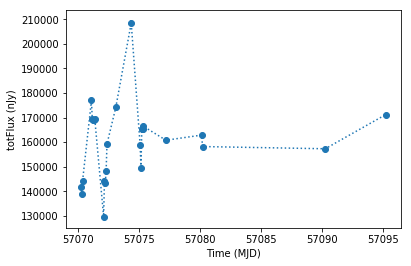

In [31]:
obj = goodObj.iloc[idx[2]]['diaObjectId']  
plotLsstLightcurve(obj, dbPath)

**Plotting curves on top of each other**
The LSST lightcurve takes in data for the y-axis that is in gTotFlux, a column in our table, that signifies brightness and variablity. To plot the curves together, we need them to be scaled the same, so we use a function to convert gToTFlux to a magnitude. After conversion and variable change for magnitude, we define a new function that takes the parameters of the HiTS light curves and the new parameters of the LSST curve and plots them together

In [32]:
#This is the function to convert flux to magnitude
lsstTestMag = (140000*u.nJy).to(u.ABmag)
print(lsstTestMag.value)

18.5346799108044


The two things we need to convert is gTotFlux and gTotFluxErr, redefined below

In [33]:
#This is now the flux in magnitude
srcTableArray=np.array(srcTableAll['totFlux']) #The equation used requires an array
mag = (srcTableArray*u.nJy).to(u.ABmag) #Apply the equation to the array of flux
srcTableAll['magCol'] = mag #Add the new output to our table
srcTableAll.head()

/epyc/users/mrawls/lsst_stack/python/miniconda3-4.5.12/envs/lsst-scipipe-f032070/lib/python3.7/site-packages/astropy/units/function/logarithmic.py:43: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


,diaSourceId,diaObjectId,ra,decl,ccdVisitId,midPointTai,apFlux,psFlux,apFluxErr,psFluxErr,totFlux,totFluxErr,flags,magCol
0,176486781787570292,176486781787570292,151.197871,2.221515,41091531,57070.141866,NaN,NaN,NaN,NaN,-20630.955068,315.430138,25299420,NaN
1,176486781787570293,176486781787570293,150.905711,2.283908,41091531,57070.141866,-4.100743e+04,-3.779699e+04,1103.226850,418.586689,48.563316,348.002515,25168348,27.184229
2,176486781787570294,176486781787570294,150.909445,2.321916,41091531,57070.141866,-4.038756e+06,-3.395545e+06,1968.619372,1530.687159,-194.198280,383.644887,25166840,NaN
3,176486781787570295,176486781787570295,150.909175,2.355545,41091531,57070.141866,2.969476e+02,2.072557e+03,1060.795183,413.023842,8852.109173,403.754943,2536,21.532383
4,176486781787570296,176486781787570296,150.910633,2.361792,41091531,57070.141866,-8.396924e+03,-1.138584e+04,1062.667154,450.717090,32932.733823,440.359122,25168332,20.105931


In [34]:
magErr = np.abs(-1.0857/srcTableAll['totFluxErr']/srcTableAll['totFlux']) #This is a new function that calculates the error 
srcTableAll['magErrCol'] = magErr #add new data to the table 
srcTableAll.head()

,diaSourceId,diaObjectId,ra,decl,ccdVisitId,midPointTai,apFlux,psFlux,apFluxErr,psFluxErr,totFlux,totFluxErr,flags,magCol,magErrCol
0,176486781787570292,176486781787570292,151.197871,2.221515,41091531,57070.141866,NaN,NaN,NaN,NaN,-20630.955068,315.430138,25299420,NaN,1.668351e-07
1,176486781787570293,176486781787570293,150.905711,2.283908,41091531,57070.141866,-4.100743e+04,-3.779699e+04,1103.226850,418.586689,48.563316,348.002515,25168348,27.184229,6.424201e-05
2,176486781787570294,176486781787570294,150.909445,2.321916,41091531,57070.141866,-4.038756e+06,-3.395545e+06,1968.619372,1530.687159,-194.198280,383.644887,25166840,NaN,1.457253e-05
3,176486781787570295,176486781787570295,150.909175,2.355545,41091531,57070.141866,2.969476e+02,2.072557e+03,1060.795183,413.023842,8852.109173,403.754943,2536,21.532383,3.037702e-07
4,176486781787570296,176486781787570296,150.910633,2.361792,41091531,57070.141866,-8.396924e+03,-1.138584e+04,1062.667154,450.717090,32932.733823,440.359122,25168332,20.105931,7.486435e-08


Now we are ready to write a function for both curves, now that we have the same axes!

In [35]:
#obj, srcTable are required by the LSST data. Row, and lcPath are variable that the HitS data requires 
def plotLsstLightcurve(obj, srcTable, row, lcPath='/epyc/users/mrawls/premap2019/hits-dr1/light_curves'):
    '''Plots light curves from HiTS dr1.'''
    '''Plots a light curve for a DIA (Difference Image Analysis) Object
    from an LSST APDB (Alert Production database).
    
    Parameters
    ----------
    obj : diaObjectId
        a really long integer that lets us retrieve sources for a single object
    objTable : Pandas dataframe containing DIA Objects
    repo : Butler repository
    dbPath : Path on disk to an APDB we can load DIA Objects or DIA Sources from
        often the database is named `association.db`
    magCol : Are we sure the magErr is correct? ...
    
    '''
    #Here we redifine what we are plotting
    plt.figure(figsize=(10,8)) #size of the figure
    srcRowFilter= (srcTable['diaObjectId'] == obj) #The object we wish to plot
    srcRow= srcTable.loc[srcRowFilter] # a tool to retrieve the data for the object
    plt.errorbar(srcRow['midPointTai'], srcRow['magCol'], yerr=srcRow['magErrCol'],
                 ls=':', marker='o') # our y-variables. Note that yerr and magCol have changed to replace gTotFlux and gTotFluxErr
#The part below is the original function from HiTS ight curves. We do not need to alter it, only remove redundant statments.    
    tok = row['internalID'].split('_')
    ccd = tok[2]
    field = '_'.join([tok[0], tok[1]])
    lightcurveFile= field + '_' + ccd + '_LC_50.tar.gz'
    #lightcurvePath= os.path.join(hitsDataDir, 'light_curves', field, ccd, lightcurveTestFile)
    tarball = tarfile.open(os.path.join(lcPath, field, ccd, lightcurveFile))
    data = tarball.extractfile(row['internalID'] + '_g.dat')
    dfl = pd.read_csv(data, sep='\t') # load a file with light curve data into the pandas dataframe
    plt.errorbar(dfl.MJD, dfl.MAG_AP1, dfl.MAGERR_AP1, marker='o', linestyle= ':')
    plt.xlabel('Time (MJD)')
    plt.ylabel('magnitude')

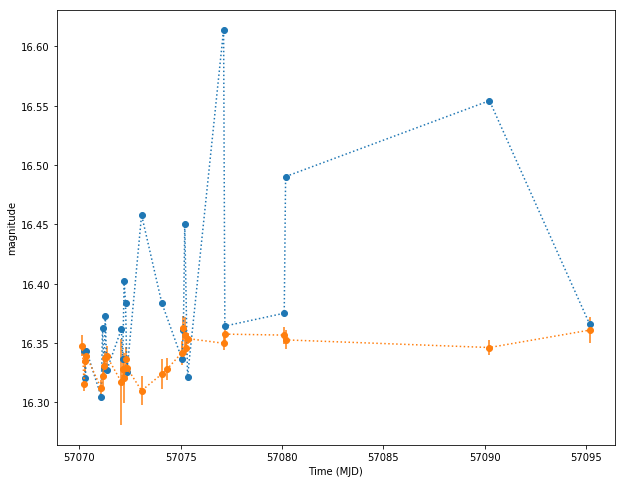

In [36]:
#Printing out the curves!
obj = goodObj.iloc[idx[11]]['diaObjectId']  
row = hitsDf.iloc[11]
plotLsstLightcurve(obj, srcTableAll, row) #We must consider both obj and row because LSST light curve depends on obj and HiTS depends on row 